In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt

import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.0


In [2]:
S_PATH = '/kaggle/input/gan-getting-started'

#GCS_PATH_MY = 'gs://kds-d7b7fde89c444e0960b3341928727ddfd0e2f862542d5977d9b189d8'
#MONET_FILENAMES = tf.io.gfile.glob('gs://monet_ds/*.tfrecords*')



In [3]:
from google.cloud import storage
project_id = 'resolute-winter-298516'
# Step 1: Get the credential from the Cloud SDK
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

# Step 2: Set the credentials
user_secrets.set_tensorflow_credential(user_credential)
s=storage.Client('resolute-winter-298516')

s=storage.Client('resolute-winter-298516')
for i in s.list_buckets():
  print(i)

<Bucket: monet_ds>
<Bucket: photo_ds>
<Bucket: rad_ds>
<Bucket: sat_ds>


In [4]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
#new
MONET_FILENAMES=tf.io.gfile.glob('gs://monet_ds/*.tfrecords*')

print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob('gs://photo_ds/photo_tfrecord/*.tfrecords*')
PHOTO_FILENAMES.append(PHOTO_FILENAMES[0])
print('Photo TFRecord Files:',len(PHOTO_FILENAMES), PHOTO_FILENAMES)
import re

print(GCS_PATH)

Monet TFRecord Files: 1
Photo TFRecord Files: 7 ['gs://photo_ds/photo_tfrecord/photo_ds.tfrecords-000', 'gs://photo_ds/photo_tfrecord/train.tfrecords-001', 'gs://photo_ds/photo_tfrecord/train.tfrecords-002', 'gs://photo_ds/photo_tfrecord/train.tfrecords-003', 'gs://photo_ds/photo_tfrecord/train.tfrecords-004', 'gs://photo_ds/photo_tfrecord/train.tfrecords-005', 'gs://photo_ds/photo_tfrecord/photo_ds.tfrecords-000']
gs://kds-939774798da0d71219fce02bd85918bbacca11f8a03ff175448d5ffc


In [5]:




IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def read_tfrecord_george(example):
    tfrecord_format = {
        "img_raw": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['img_raw'])
    return image
def load_dataset_george(filenames, labeled=True, ordered=False, augmentDS = False, repeat=False, shuffle = False, batch_size=1):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord_george, num_parallel_calls=AUTOTUNE)
    if repeat:
        dataset = dataset.repeat(2)
        print('repeated')
    if augmentDS:
        print('augmented')
        dataset = dataset.map(augment,num_parallel_calls=AUTOTUNE) 
    if shuffle:
        dataset = dataset.shuffle(2048)
        print('shuffled')
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [6]:
def augment(image):
    p_rotate = .1#tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    image = tf.image.resize(image, (300,300))
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    image = tf.image.random_crop(image, [256,256,3])
    
    
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False, augmentDS = False, repeat=False, shuffle = False, batch_size=1):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    if repeat:
        dataset = dataset.repeat(4)
        print('repeated')
    if augmentDS:
        print('augmented')
        dataset = dataset.map(augment,num_parallel_calls=AUTOTUNE) 
    if shuffle:
        dataset = dataset.shuffle(2048)
        print('shuffled')
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

shuffled
shuffled


<PrefetchDataset shapes: (None, 256, 256, 3), types: tf.float32>

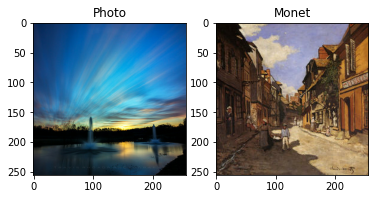

In [8]:
#monet_ds = load_dataset(MONET_FILENAMES, labeled=True, augmentDS = False, repeat=True,shuffle = True, batch_size=32)
#photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True, augmentDS = False, repeat=True,shuffle = True, batch_size=32)
monet_ds = load_dataset_george(MONET_FILENAMES, labeled=True, augmentDS = False, repeat=False,shuffle = True,
                               batch_size=16)
photo_ds = load_dataset_george(PHOTO_FILENAMES, labeled=True, augmentDS = False, repeat=False,shuffle = True,
                               batch_size=16)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
monet_ds

In [9]:
!ls

__notebook__.ipynb


In [10]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
j=0
for i in monet_ds:
    j=j+1
print(j)

67


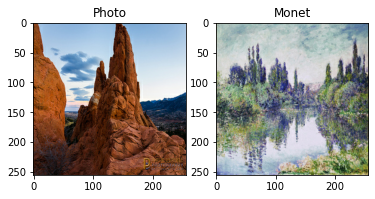

In [11]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [12]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [13]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [14]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
OUTPUT_CHANNELS = 3
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos
    
monet_generator.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  524800      sequential_1[0][0]               
______________________________________________________________________________________________

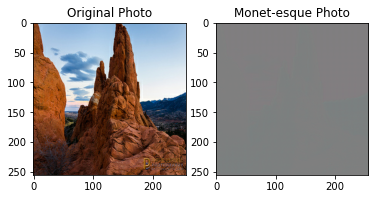

In [17]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [18]:
class CycleGan(keras.Model):
    def __init__(
    self,
    monet_generator,
    photo_generator,
    monet_discriminator,
    photo_discriminator,
    lambda_cycle=10,
    ):
        super(CycleGan,self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,
               m_gen_optimizer,
               p_gen_optimizer,
               m_disc_optimizer,
               p_disc_optimizer,
               gen_loss_fn,
               disc_loss_fn,
               cycle_loss_fn,
               identity_loss_fn,
               ):
        super(CycleGan, self).compile(
        )
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self,batch_data):
        real_monet, real_photo = batch_data
    
        with tf.GradientTape(persistent=True) as tape:
            #photo => fake monet
            fake_monet = self.m_gen(real_photo, training = True)
            #fake monet => photo
            cycled_photo = self.p_gen(fake_monet, training = True)
            
            #monet to photo
            fake_photo = self.p_gen(real_monet, training = True)
            #photo to monet
            cycled_monet = self.m_gen(fake_photo, training = True)
            
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            
            #check inputting fake images
            disc_fake_monet = self.m_disc(fake_monet, training = True)
            disc_fake_photo = self.p_disc(fake_photo,training = True)
            

            #generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            #total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet,cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            #total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet,disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
            monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
            photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)
            
            monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
            photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
            
            self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))
            self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
            
            self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))
            self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
            
            return{
                "monet_gen_loss": total_monet_gen_loss,
                "photo_gen_loss": total_photo_gen_loss,
                "monet_disc_loss": monet_disc_loss,
                "photo_disc_loss": photo_disc_loss
            }
                

In [19]:
### Compares Real images to matrix of 1s 
### Compares Fake Images to matrix of 0s
# => perfect disc will output 1s for real, 0s for fake
#disc loss is average of real and generated loss

In [20]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                       reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
        
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                            reduction= tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
        
        
        
        
        
        

In [21]:
### gen tries to fool disc generated image is real
## perfect gen will have disc output 1s
### ergo, compares generated image to matrix of 1s to find loss

In [22]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)
        

In [23]:
##Original photo and twice transformed photo to be similar

In [24]:
with strategy.scope():
    def calc_cycle_loss(real_image,cycled_image,LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image-cycled_image))
        return LAMBDA * loss1

In [25]:
###identity loss compares image with generator

In [26]:
with strategy.scope():
    def identity_loss(real_image,same_image,LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image-same_image))
        return LAMBDA * 0.5 * loss

In [27]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_30 (Sequential)   (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_31 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_32 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 31, 31, 512)       2097152   
_________________________________________________________________
instance_normalization_30 (I (None, 31, 31, 512)       1024

(-0.5, 255.5, 255.5, -0.5)

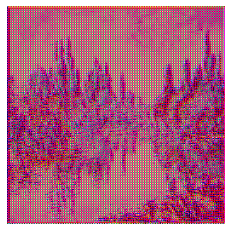

In [28]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss,    
    )
    
monet_discriminator.summary()
random_img = monet_generator(example_monet *127.5 + 127.5)
random_img = random_img[0]
plt.imshow(random_img)
plt.axis('off')

In [29]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        _ = plt.figure(figsize = (15,5))


        fake_monet = monet_generator(example_photo)[0]

        plt.subplot(1,2, 1)
        plt.imshow(tf.cast(fake_monet * 127.5 + 127.5, tf.uint8))
        plt.title("monet generator")

        plt.show()



def show_progress():
    
    """
    function that takes 4 examples of each sample dataset to show its progress while training
    """

    photo_iter = iter(photo_ds)
        
    _ = plt.figure(figsize = (15,5))
        
        
    fake_monet = monet_generator(example_photo)[0]

    plt.subplot(1,2, 1)
    plt.imshow(tf.cast(fake_monet * 127.5 + 127.5, tf.uint8))
    plt.title("monet generator")
            
    plt.show()

In [30]:
epochs = 700
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds,photo_ds)),
    epochs=epochs, verbose=1,batch_size=16
)

Epoch 1/700
67/67 [==============================] - 117s 131ms/step - monet_gen_loss: 7.3887 - photo_gen_loss: 7.6271 - monet_disc_loss: 0.6194 - photo_disc_loss: 0.6163
Epoch 2/700
67/67 [==============================] - 9s 131ms/step - monet_gen_loss: 4.7297 - photo_gen_loss: 4.8728 - monet_disc_loss: 0.5984 - photo_disc_loss: 0.5267
Epoch 3/700
67/67 [==============================] - 9s 131ms/step - monet_gen_loss: 4.0690 - photo_gen_loss: 4.4227 - monet_disc_loss: 0.6207 - photo_disc_loss: 0.4111
Epoch 4/700
67/67 [==============================] - 9s 131ms/step - monet_gen_loss: 3.8542 - photo_gen_loss: 4.3847 - monet_disc_loss: 0.5377 - photo_disc_loss: 0.3411
Epoch 5/700
67/67 [==============================] - 9s 131ms/step - monet_gen_loss: 4.0892 - photo_gen_loss: 4.5304 - monet_disc_loss: 0.4856 - photo_disc_loss: 0.3736
Epoch 6/700
67/67 [==============================] - 9s 131ms/step - monet_gen_loss: 4.3124 - photo_gen_loss: 4.5034 - monet_disc_loss: 0.4657 - photo_di

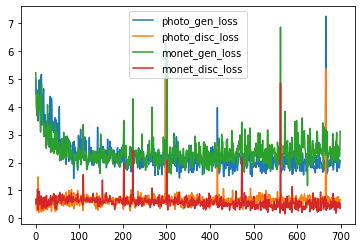

In [31]:
def showEpochLoss(epochs):
    fig, ax = plt.subplots()
    p_gen = history.history['photo_gen_loss']
    p_dis = history.history['photo_disc_loss']
    m_gen = history.history['monet_gen_loss']
    m_dis = history.history['monet_disc_loss']
    s = len(p_gen[0][0][:][:])

    arr=[]
    arr_pdis= []
    arr_m_gen = []
    arr_m_dis = []
    for i in range(epochs):
        arr.append(np.sum(p_gen[i][0][:][:])/s**2)
        arr_pdis.append(np.sum(p_dis[i][0][:][:])/s**2)
        arr_m_gen.append(np.sum(m_gen[i][0][:][:])/s**2)
        arr_m_dis.append(np.sum(m_dis[i][0][:][:])/s**2)

    ax.plot(arr,label='photo_gen_loss')
    ax.plot(arr_pdis,label='photo_disc_loss')
    ax.plot(arr_m_gen,label='monet_gen_loss')
    ax.plot(arr_m_dis,label='monet_disc_loss')
    ax.legend()  # Add a legend.
    
    
showEpochLoss(epochs)



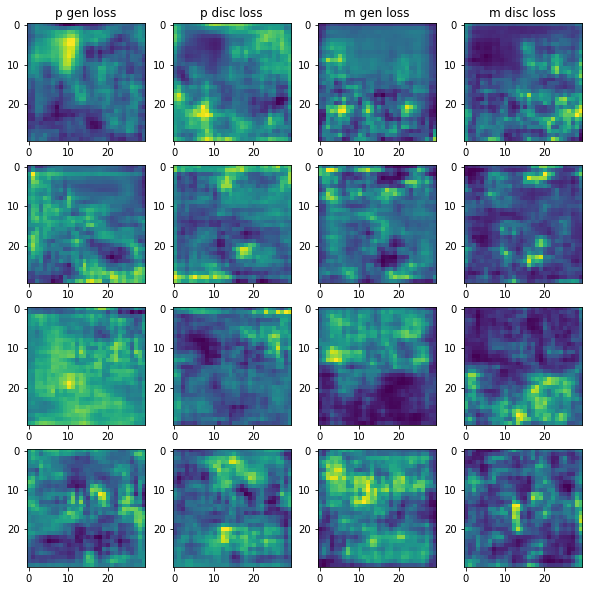

In [32]:
n_plots = 4

_, ax = plt.subplots(n_plots, 4, figsize=(10, 10))
for i, img in enumerate(zip(
history.history['photo_gen_loss'],
 history.history['photo_disc_loss'],
 history.history['monet_gen_loss'],
 history.history['monet_disc_loss'],
)):
    if i < epochs-n_plots:
        continue
    ax[i-epochs+n_plots, 0].imshow(img[0][0])
    ax[i-epochs+n_plots, 1].imshow(img[1][0])
    ax[i-epochs+n_plots, 2].imshow(img[2][0])
    ax[i-epochs+n_plots, 3].imshow(img[3][0])
ax[0,0].title.set_text('p gen loss')
ax[0,1].title.set_text('p disc loss')
ax[0,2].title.set_text('m gen loss')
ax[0,3].title.set_text('m disc loss')
plt.show()


In [33]:
#_, ax = plt.subplots(10, 2, figsize=(52, 52))
#for i, img in enumerate(photo_ds.take(10)):
#    prediction = monet_generator(img, training=False)[0].numpy()
 #   prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
  #  img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
#
 #   ax[i, 0].imshow(img)
  #  ax[i, 1].imshow(prediction)
   # ax[i, 0].set_title("Input Photo")
#    #ax[i, 1].set_title("Monet-esque")
#    ax[i, 0].axis("off")
 #   ax[i, 1].axis("off")
#plt.show()

In [34]:
import PIL
! mkdir ../images

In [35]:

i = 1
photo_ds = load_dataset_george(PHOTO_FILENAMES, labeled=True)
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    print(i)
    i += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [36]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'